In [1]:
from __future__ import print_function, division
%matplotlib inline
from matplotlib import pyplot as plt
import json
import random
import numpy as np
import debiaswe as dwe
import debiaswe.we as we
from debiaswe.we import WordEmbedding
from debiaswe.debias import debias
from sklearn.decomposition import PCA

## Replicate gender debias using Google News

In [2]:
# load subset of word embedding trained on Google News text
# E = WordEmbedding("./embeddings/GoogleNews-vectors-negative300-hard-debiased.bin")
E = WordEmbedding("./embeddings/w2v_gnews_small.txt")

*** Reading data from ./embeddings/w2v_gnews_small.txt
(26423, 300)
26423 words of dimension 300 : in, for, that, is, ..., Jay, Leroy, Brad, Jermaine


In [3]:
# she−he gender direction on g2vNEWS
gender_direction = E.diff("she", "he")

# appendix A: generating analogies
gender_analogies = E.best_analogies_dist_thresh(gender_direction)

Computing neighbors
Mean: 10.219732808538016
Median: 7.0


In [4]:
# print gender analogies
for (a,b,c) in gender_analogies[:20]:
    print(a+"-"+b)

she-he
herself-himself
her-his
woman-man
daughter-son
businesswoman-businessman
girl-boy
actress-actor
chairwoman-chairman
heroine-hero
mother-father
spokeswoman-spokesman
sister-brother
girls-boys
sisters-brothers
queen-king
niece-nephew
councilwoman-councilman
motherhood-fatherhood
women-men


In [5]:
# load professions file
with open("./data/professions.json", 'r') as f:
    professions = json.load(f)

In [6]:
# show gender bias in word vectors associated with professions
# sort by projection score in the direction of gender
# equivalent to Fig 1
gender_bias_projection_score = sorted([(E.v(w).dot(gender_direction), w) for w in professions])

print('Extreme she occupations')
print(gender_bias_projection_score[-20:])

print('\n\nExtreme he occupations')
print(gender_bias_projection_score[0:20])

Extreme she occupations
[(0.19714224, u'interior_designer'), (0.20833439, u'housekeeper'), (0.21560375, u'stylist'), (0.2236317, u'bookkeeper'), (0.23776126, u'maid'), (0.24125955, u'nun'), (0.24782579, u'nanny'), (0.24929334, u'hairdresser'), (0.24946158, u'paralegal'), (0.25276464, u'ballerina'), (0.25718823, u'socialite'), (0.26647124, u'librarian'), (0.27317622, u'receptionist'), (0.27540293, u'waitress'), (0.28085968, u'nurse'), (0.3042623, u'registered_nurse'), (0.3043797, u'homemaker'), (0.3403659, u'housewife'), (0.3523514, u'actress'), (0.35965404, u'businesswoman')]


Extreme he occupations
[(-0.23798442, u'maestro'), (-0.21665451, u'statesman'), (-0.20758669, u'skipper'), (-0.20267202, u'protege'), (-0.2020676, u'businessman'), (-0.19492392, u'sportsman'), (-0.18836352, u'philosopher'), (-0.1807366, u'marksman'), (-0.1728986, u'captain'), (-0.16785555, u'architect'), (-0.16702037, u'financier'), (-0.16313636, u'warrior'), (-0.15280862, u'major_leaguer'), (-0.15001445, u'trum

### 5.2 direct bias

In [7]:
# direct bias
# identify gender-neutral words
with open('./data/definitional_pairs.json', "r") as f:
    definitional = json.load(f)

In [8]:
vector_differences = []
for a, b in definitional:
    center = (E.v(a) + E.v(b))/2
    vector_differences.append(E.v(a) - center)
    vector_differences.append(E.v(b) - center)
vector_differences = np.array(vector_differences)

In [9]:
pca = PCA(n_components=10)
result = pca.fit_transform(vector_differences)

<BarContainer object of 10 artists>

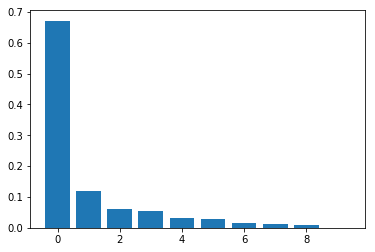

In [10]:
plt.bar(range(result.shape[1]),pca.explained_variance_ratio_)

### 5.3 indirect bias

In [11]:
# plot created using R 
# export "gender_bias_projection_score" as file

# library(ggplot2)
# library(ggrepel)

# small_set <- read.table("~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/data/gender_profession_subset-5.3.txt", header = F, stringsAsFactors = F)
# gender_bias_projection_score <- read.csv("~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/data/gender_bias_projection_score-5.3.txt", header = F, stringsAsFactors = F )
# gender_bias_projection_score <- subset(gender_bias_projection_score, V2 %in% small_set$V1)
# png('~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/r-plots/gender_bias_projection_score-5.3.png', units="in", width=4, height=2.6, res=500)
# ggplot(data = gender_bias_projection_score, aes(x = V1, y = 0)) +
#   geom_vline(xintercept = 0, size=0.2, linetype = "dashed", colour = "red") +
#   # geom_hline(yintercept = 0, size=0.1, colour = "grey") +
#   geom_text_repel(aes(label = V2), direction = "y", size=1.5,
#                   box.padding = unit(0.1, "lines"),
#                   color = "black", segment.alpha=0) +
#   theme_bw() +
#   theme(axis.title.y=element_blank(),
#         axis.text.y=element_blank(),
#         axis.ticks.y=element_blank(),
#         axis.title.x=element_blank(),
#         axis.text.x=element_blank(),
#         axis.ticks.x=element_blank(),
#         panel.grid.major = element_blank(),
#         panel.grid.minor = element_blank(),
#         panel.border = element_blank(),
#         panel.background = element_blank(),
#         legend.position="none"
#   )
# dev.off()  


![caption](./r-plots/gender_bias_projection_score-5.3.png)

### 6 debiasing algorithm

In [11]:
# 7 Determining gender neutral words
with open('./data/equalize_pairs.json', "r") as f:
    equalize = json.load(f)

with open('./data/gender_specific_full.json', "r") as f:
    gender_specific = json.load(f)

In [12]:
# perform debiasing
debias(E, gender_specific, definitional, equalize)

26423 words of dimension 300 : in, for, that, is, ..., Jay, Leroy, Brad, Jermaine
set([(u'Dad', u'Mom'), (u'fathers', u'mothers'), (u'Gelding', u'Mare'), (u'twin_brother', u'twin_sister'), (u'HIMSELF', u'HERSELF'), (u'GRANDSONS', u'GRANDDAUGHTERS'), (u'KING', u'QUEEN'), (u'FRATERNITY', u'SORORITY'), (u'prince', u'princess'), (u'men', u'women'), (u'FATHERHOOD', u'MOTHERHOOD'), (u'Dudes', u'Gals'), (u'DADS', u'MOMS'), (u'BOYS', u'GIRLS'), (u'nephew', u'niece'), (u'Father', u'Mother'), (u'He', u'She'), (u'Grandfather', u'Grandmother'), (u'Spokesman', u'Spokeswoman'), (u'Brother', u'Sister'), (u'FATHERS', u'MOTHERS'), (u'UNCLE', u'AUNT'), (u'gelding', u'mare'), (u'Himself', u'Herself'), (u'his', u'her'), (u'Son', u'Daughter'), (u'prostate_cancer', u'ovarian_cancer'), (u'BROTHER', u'SISTER'), (u'chairman', u'chairwoman'), (u'MEN', u'WOMEN'), (u'gentlemen', u'ladies'), (u'SON', u'DAUGHTER'), (u'king', u'queen'), (u'Colt', u'Filly'), (u'councilman', u'councilwoman'), (u'SPOKESMAN', u'SPOKESWO

### 8 debiasing results

In [13]:
# check again for gender bias in professions after debiasing
gender_debiased_projection_score = sorted([(E.v(w).dot(gender_direction), w) for w in professions])

print('Extreme she occupations')
print(gender_debiased_projection_score[-20:])

print('\n\nExtreme he occupations')
print(gender_debiased_projection_score[0:20])

Extreme she occupations
[(0.033643793, u'student'), (0.03403571, u'illustrator'), (0.034525253, u'patrolman'), (0.034747534, u'hairdresser'), (0.037651695, u'foreman'), (0.0377223, u'carpenter'), (0.037771206, u'pastor'), (0.038419843, u'nanny'), (0.04051316, u'janitor'), (0.043088164, u'firefighter'), (0.047822054, u'wrestler'), (0.06411566, u'teenager'), (0.23776129, u'maid'), (0.24125956, u'nun'), (0.25276467, u'ballerina'), (0.25718823, u'socialite'), (0.27540293, u'waitress'), (0.34036583, u'housewife'), (0.3523514, u'actress'), (0.4058326, u'businesswoman')]


Extreme he occupations
[(-0.4154882, u'congressman'), (-0.4115872, u'businessman'), (-0.32975563, u'councilman'), (-0.2997815, u'dad'), (-0.21665451, u'statesman'), (-0.11345412, u'salesman'), (-0.073004864, u'monk'), (-0.072163954, u'handyman'), (-0.041478336, u'commander'), (-0.04051176, u'minister'), (-0.037369348, u'skipper'), (-0.036916208, u'commissioner'), (-0.03343007, u'observer'), (-0.032828867, u'manager'), (-0.0

### verify debias by word projection on x axis

In [ ]:
# plot created using R 
# export "gender_debiased_projection_score" as file

# library(ggplot2)
# library(ggrepel)

# small_set <- read.table("~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/data/gender_profession_subset-5.3.txt", header = F, stringsAsFactors = F)
# gender_debiased_projection_score <- read.csv("~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/data/gender_debiased_projection_score-5.3.txt", header = F)
# gender_debiased_projection_score <- subset(gender_debiased_projection_score, V2 %in% small_set$V1)
# png('~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/r-plots/gender_debiased_projection_score-5.3.png', units="in", width=4, height=2.6, res=500)
# ggplot(data = gender_debiased_projection_score, aes(x = V1, y = 0)) +
#   geom_vline(xintercept = 0, size=0.2, linetype = "dashed", colour = "red") +
#   # geom_hline(yintercept = 0, size=0.1, colour = "grey") +
#   geom_text_repel(aes(label = V2), direction = "y", size=1.5,
#                   box.padding = unit(0.1, "lines"),
#                   color = "black", segment.alpha=0) +
#   theme_bw() +
#   theme(axis.title.y=element_blank(),
#         axis.text.y=element_blank(),
#         axis.ticks.y=element_blank(),
#         axis.title.x=element_blank(),
#         axis.text.x=element_blank(),
#         axis.ticks.x=element_blank(),
#         panel.grid.major = element_blank(),
#         panel.grid.minor = element_blank(),
#         panel.border = element_blank(),
#         panel.background = element_blank(),
#         legend.position="none"
#   )
# dev.off()   


![caption](./r-plots/gender_debiased_projection_score-5.3.png)

## Politics debias using Jenni's embeddings

In [125]:
E2 = WordEmbedding("./embeddings/article_embed.txt")

*** Reading data from ./embeddings/article_embed.txt
(462643, 50)
462643 words of dimension 50 : the, to, of, and, ..., sadaoui, craythorn, calcraft, coventon
462643 words of dimension 50 : the, to, of, and, ..., sadaoui, craythorn, calcraft, coventon


In [232]:
# "democrats-republicans on Jenni's embeddings
politics_direction = E2.diff("democrats", "republicans")

# appendix A: generating analogies
politics_analogies = E2.best_analogies_dist_thresh(politics_direction)

Computing neighbors
Mean: 1368.8884
Median: 609.0


In [16]:
# print gender analogies
for (a,b,c) in politics_analogies:
    print(a+'-'+b)

NameError: name 'politics_analogies' is not defined

In [249]:
# load professions file for Jenni's embeddings
with open("./data/professions_jenni.json", 'r') as f:
    professions_j = json.load(f)

In [270]:
political_bias_projection_score = sorted([(E2.v(w).dot(politics_direction), w) for w in professions_j])

print('Extreme democrats occupations')
print(political_bias_projection_score[-20:])

print('\n\nExtreme republicans occupations')
print(political_bias_projection_score[0:20])

Extreme democrats occupations
[(3.8567123e-08, u'archaeologist'), (3.9319275e-08, u'warrior'), (3.9552106e-08, u'protagonist'), (4.0483428e-08, u'banker'), (4.2375177e-08, u'editor'), (4.2869942e-08, u'artist'), (4.3510227e-08, u'broadcaster'), (4.4736225e-08, u'writer'), (4.485446e-08, u'filmmaker'), (4.5110937e-08, u'manager'), (4.5454726e-08, u'swimmer'), (4.991307e-08, u'vocalist'), (5.2531504e-08, u'composer'), (6.4428605e-08, u'economist'), (0.35618472, u'firebrand'), (0.36872655, u'adventurer'), (0.38532493, u'pollster'), (0.40796793, u'pundit'), (0.41396058, u'journalist'), (0.44235626, u'cartoonist')]


Extreme republicans occupations
[(-0.43503612, u'preacher'), (-0.43494287, u'commentator'), (-0.43112683, u'sociologist'), (-0.42421684, u'cameraman'), (-0.39868182, u'parliamentarian'), (-0.32313955, u'crusader'), (-0.24420993, u'playwright'), (-6.998016e-08, u'advocate'), (-3.5915946e-08, u'magistrate'), (-3.279456e-08, u'landlord'), (-3.1199306e-08, u'paralegal'), (-3.064633

### 5.2 direct bias

In [10]:
# direct bias
with open('./data/definitional_pairs_jenni.json', "r") as f:
    definitional_j = json.load(f)

In [273]:
vector_differences_j = []
for a, b in definitional_j:
    center = (E2.v(a) + E2.v(b))/2
    vector_differences_j.append(E2.v(a) - center)
    vector_differences_j.append(E2.v(b) - center)
vector_differences_j = np.array(vector_differences_j)

In [274]:
pca_j = PCA(n_components=10)
result_j = pca_j.fit_transform(vector_differences_j)

<BarContainer object of 10 artists>

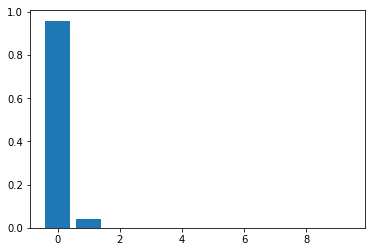

In [275]:
plt.bar(range(result_j.shape[1]),pca_j.explained_variance_ratio_)

### 5.3 indirect bias

In [ ]:
# plot created using R 
# export "political_bias_projection_score" as file

# library(ggplot2)
# library(ggrepel)

# political_bias_projection_score <- read.csv("~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/data/political_bias_projection_score-5.3.txt", header = F)
# png('~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/r-plots/political_bias_projection_score-5.3.png', units="in", width=6, height=5, res=500)
# ggplot(data = political_bias_projection_score, aes(x = V1, y = 0)) +
#   geom_vline(xintercept = 0, size=0.2, linetype = "dashed", colour = "red") +
#   geom_hline(yintercept = 0, size=0.1, colour = "grey") +
#   geom_text_repel(aes(label = V2), direction = "y", size=1.5,
#                   box.padding = unit(0.1, "lines"),
#                   color = "black", segment.alpha=0) +
#   theme_bw() +
#   theme(axis.title.y=element_blank(),
#         axis.text.y=element_blank(),
#         axis.ticks.y=element_blank(),
#         axis.title.x=element_blank(),
#         axis.text.x=element_blank(),
#         axis.ticks.x=element_blank(),
#         panel.grid.major = element_blank(),
#         panel.grid.minor = element_blank(),
#         panel.border = element_blank(),
#         panel.background = element_blank(),
#         legend.position="none"
#   )
# dev.off()  
